In [91]:
%load_ext autoreload
%autoreload 2
from etr.auto_import import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data
---

In [2]:
import itertools
def read(sym, year):
    return [pd.read_parquet(file) for file in Path(f"../../data/gmo/{sym}/").glob(f"*{year}*.parquet")]

data = []
for sym, year in tqdm(itertools.product(
    ["BTC_JPY", "ETH_JPY", "LTC_JPY", "XRP_JPY"],
    [2019, 2020, 2021, 2022, 2023, 2024, 2025],
)):
    data += read(sym, year)
    
data = pd.concat(data)

0it [00:00, ?it/s]

### preprocess

In [3]:
%%time
freq = "10min"
ohlc = data.set_index("timestamp").groupby("symbol").resample(freq, label="right").price.ohlc()
v = data.set_index("timestamp").groupby(["symbol", "side"]).resample(freq, label="right")["size"].sum()

# Form OHLCV
ohlcv = ohlc.join(v.unstack(level=1))
ohlcv["volume"] = ohlcv.BUY + ohlcv.SELL
ohlcv["v_imbalance"] = ohlcv.BUY.fillna(0) - ohlcv.SELL.fillna(0)

CPU times: user 1min 51s, sys: 34.8 s, total: 2min 26s
Wall time: 2min 26s


In [265]:
# as timeseries
close = ohlcv.close.unstack(level=0).ffill()
cc = np.log(close.pct_change().add(1)).rename(lambda x: f"CC_{x[0]}", axis=1)
hl = np.log(ohlcv.high.unstack(level=0).div(ohlcv.low.unstack(level=0))).fillna(0).rename(lambda x: f"HL_{x[0]}", axis=1)
v_imb = ohlcv.v_imbalance.unstack(level=0).fillna(0).rename(lambda x: f"VI_{x[0]}", axis=1)
v_tot = ohlcv.volume.unstack(level=0).fillna(0).rename(lambda x: f"VT_{x[0]}", axis=1)

horizon = 1
target_ret = np.log(close.shift(-horizon) / close)
label = target_ret.div(target_ret.rolling("1d").std()).dropna().clip(-4, +4)  # regression
# label = target_ret.sub(target_ret.rolling("90d").mean()).dropna().ge(0)
features = pd.concat([cc, hl, v_imb, v_tot], axis=1)
features_norm = features.sub(features.rolling("7D").mean()).div(features.rolling("7D").std()).clip(-4, +4)
features_norm["W"] = features_norm.index.weekday
features_norm["H"] = features_norm.index.hour
dataset = label.join(features_norm).dropna()

In [266]:
target_ccy = "LTC_JPY"
X, y = dataset.iloc[:, label.shape[1]:], dataset[target_ccy]

In [231]:
X.head(3)

symbol,CC_B,CC_E,CC_L,CC_X,HL_B,HL_E,HL_L,HL_X,VI_B,VI_E,VI_L,VI_X,VT_B,VT_E,VT_L,VT_X,W,H
timestamp,,,,,,,,,,,,,,,,,,
2019-01-31 15:50:00,0.117914,-0.002511,-4.000000,-0.033367,0.090766,-0.046485,4.000000,-0.146437,1.292230,-0.003736,4.000000,0.031381,0.550421,-0.083729,4.000000,-0.083237,3,15
2019-01-31 16:00:00,-0.073876,-0.002503,-0.009003,-0.033276,0.510377,-0.046485,-0.031497,-0.146437,1.188593,-0.003736,0.009284,0.031381,0.425287,-0.083729,-0.056405,-0.083237,3,16
2019-01-31 16:10:00,0.033880,-0.002496,-0.008979,2.144291,-0.819205,-0.046485,-0.031497,-0.146437,0.067231,-0.003736,0.009284,0.063301,-0.509022,-0.083729,-0.056405,-0.065327,3,16


In [232]:
y.describe()

count    328476.000000
mean          0.003162
std           0.955938
min          -4.000000
25%          -0.061648
50%           0.000000
75%           0.082968
max           4.000000
Name: LTC_JPY, dtype: float64

## Train
---

In [276]:
from etr.research.mt_garch.lstm_transformer import *
def create_model():
    return LSTMTransformerWrapper(
        total_input_dim=X.shape[1],
        cat_index={-2: 7, -1: 24}, 
        seq_len=144,
        activation=nn.Identity(), 
        criterion=nn.MSELoss(),
        lr=0.0005,
    )

In [277]:
# rolling buckets
rolling_freq = "6M"
time_buckets = X.index.to_frame("timestamp").resample(rolling_freq).timestamp.agg(["min", "max"]).set_axis(["t0", "t1"], axis=1)
time_buckets = time_buckets.loc[time_buckets.t0 > X.index.min() + pd.Timedelta("365D")]

In [278]:
models = {}
predictions = []
for t, (t0, t1) in tqdm(time_buckets.iterrows(), total=len(time_buckets)):
    # train
    model = create_model()
    model.fit_dataframe(
        X_df = X.loc[:t0 - pd.Timedelta(1)],
        y_df = y.loc[:t0 - pd.Timedelta(1)],
        val_split=0.2
    )
    models[t] = model
    
    # eval
    x_test, y_test = X.loc[t0:t1], y.loc[t0:t1]
    pred = model.predict_dataframe(x_test).numpy().reshape(-1,)
    pred = pd.Series(pred, index=x_test.index[-pred.shape[0]:], name="pred")
    predictions.append(pred)
    
predictions = pd.concat(predictions)

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [1/100] Train Loss: 0.8564 | Val Loss: 0.8972
Epoch [2/100] Train Loss: 0.8535 | Val Loss: 0.8972
Epoch [3/100] Train Loss: 0.8532 | Val Loss: 0.8973
Epoch [4/100] Train Loss: 0.8529 | Val Loss: 0.8973
Epoch [5/100] Train Loss: 0.8531 | Val Loss: 0.8972
Epoch [6/100] Train Loss: 0.8529 | Val Loss: 0.8972
Epoch [7/100] Train Loss: 0.8528 | Val Loss: 0.8972
Epoch [8/100] Train Loss: 0.8529 | Val Loss: 0.8974
Epoch [9/100] Train Loss: 0.8527 | Val Loss: 0.8979
Epoch [10/100] Train Loss: 0.8528 | Val Loss: 0.8971
Epoch [11/100] Train Loss: 0.8526 | Val Loss: 0.8973
Epoch [12/100] Train Loss: 0.8526 | Val Loss: 0.8971
Epoch [13/100] Train Loss: 0.8527 | Val Loss: 0.8971
Epoch [14/100] Train Loss: 0.8526 | Val Loss: 0.8970
Epoch [15/100] Train Loss: 0.8525 | Val Loss: 0.8970
Epoch [16/100] Train Loss: 0.8527 | Val Loss: 0.8969
Epoch [17/100] Train Loss: 0.8523 | Val Loss: 0.8969
Epoch [18/100] Train Loss: 0.8526 | Val Loss: 0.8968
Epoch [19/100] Train Loss: 0.8523 | Val Loss: 0.8969
Ep

KeyboardInterrupt: 

In [281]:
# predictions = pd.concat(predictions)

In [282]:
pred = predictions.to_frame("pred").join(target_ret[target_ccy])

In [283]:
pred.corr(method="spearman")

,pred,LTC_JPY
pred,1.000000,0.003937
LTC_JPY,0.003937,1.000000


In [284]:
pred.corr()

,pred,LTC_JPY
pred,1.000000,0.002221
LTC_JPY,0.002221,1.000000


In [285]:
pred.pred.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
pred,26065.0,0.001047,0.032645,-0.17333,-0.017437,0.011591,0.026012,0.042549


In [286]:
pred.groupby(pd.qcut(pred.pred, q=np.arange(0, 1.01, 0.1)))[target_ccy].mean().mul(1e4).to_frame()

,LTC_JPY
pred,
"(-0.174, -0.0452]",0.653728
"(-0.0452, -0.0253]",-1.400028
"(-0.0253, -0.0098]",-0.726615
"(-0.0098, 0.00396]",0.951131
"(0.00396, 0.0116]",-1.735279
"(0.0116, 0.0193]",-0.716745
"(0.0193, 0.0243]",1.280184
"(0.0243, 0.0278]",1.207397
"(0.0278, 0.0318]",-0.721028


<Axes: xlabel='timestamp'>

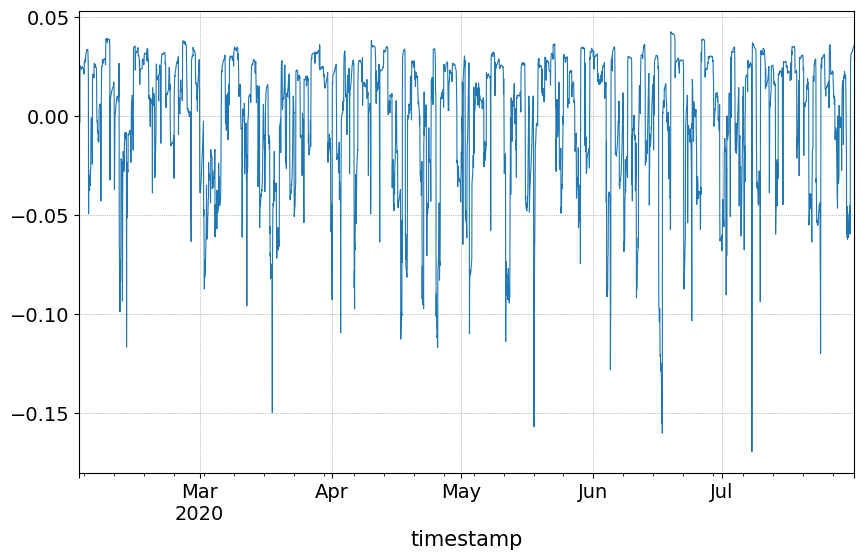

In [287]:
pred.pred.resample("1h").last().plot()

/home/tarai/.pyenv/versions/anaconda3-2022.10/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='pred', ylabel='LTC_JPY'>

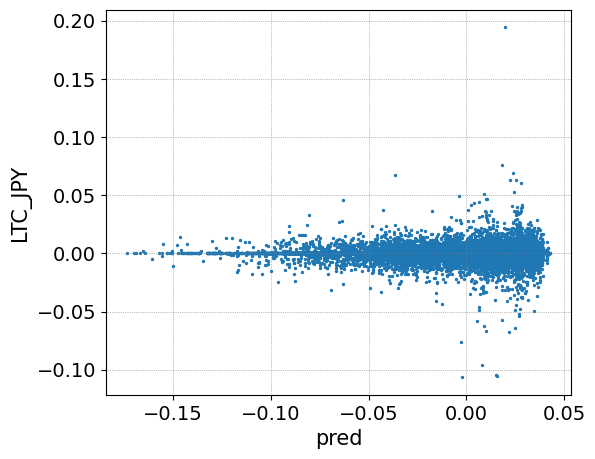

In [288]:
pred.plot.scatter(x="pred", y=target_ccy, figsize=(6, 5), s=2)

<Axes: xlabel='timestamp'>

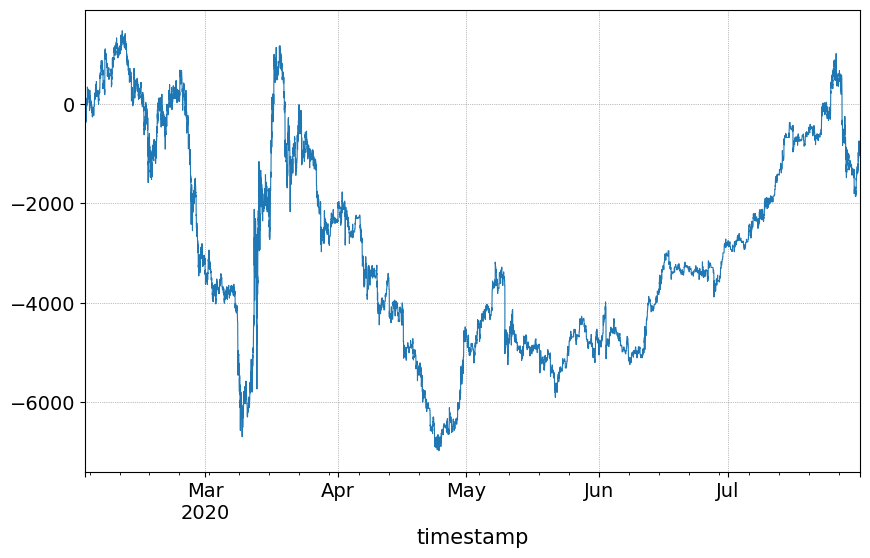

In [289]:
(pred[target_ccy] * np.sign(pred.pred.sub(pred.pred.mean()))).mul(1e4).cumsum().plot()

In [290]:
(pred[target_ccy] * np.sign(pred.pred.sub(pred.pred.mean()))).mul(1e4).describe()

count    26065.000000
mean        -0.033694
std         53.240655
min      -1055.059596
25%          0.000000
50%          0.000000
75%          0.000000
max       1943.182731
dtype: float64

<Axes: >

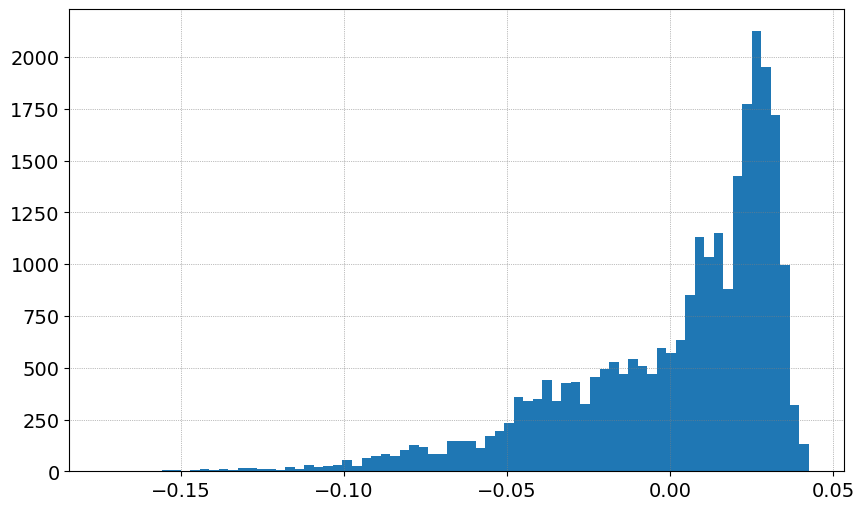

In [291]:
pred.pred.hist(bins="auto")

---

<Axes: xlabel='timestamp'>

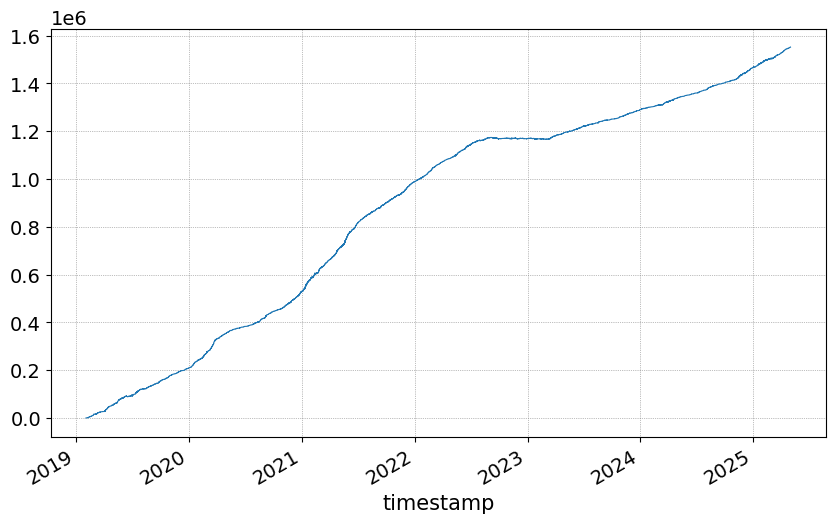

In [274]:
(target_ret[target_ccy].loc[X.index] * np.sign(X.CC_B)).mul(1e4).cumsum().plot()